In [1]:
import polars as pl

cr_f = '/mnt/eqa/zhangyuanfeng/methylation/evaluated/cr_informed.csv'

cr: pl.DataFrame
cr = (pl.read_csv(cr_f)
        .filter(~pl.col('sample').str.contains('HF'))
        .filter(pl.col('lab') != 'RR1')
        .with_columns(pl.when(pl.col('lab').str.contains('PS'))
                        .then(pl.col('lambda'))
                        .otherwise(100 - pl.col('lambda'))
                        .alias('lambda_gap'),
                      pl.when(pl.col('lab').str.contains('PS'))
                        .then(100 - pl.col('pUC19'))
                        .otherwise(pl.col('pUC19'))
                        .alias('pUC19_gap'))
        .with_columns(pl.sum_horizontal('lambda_gap',
                                        'pUC19_gap')
                        .alias('conversion_bias')))
cr

lab,sample,chrM_avg_beta,lambda_avg_beta,pUC19_avg_beta,chrM,lambda,pUC19,lambda_gap,pUC19_gap,conversion_bias
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""BS1""","""BC_1""",0.510245,0.51528,95.529015,99.489755,99.48472,4.470985,0.51528,4.470985,4.986265
"""BS1""","""BC_2""",0.461833,0.453165,95.639268,99.538167,99.546835,4.360732,0.453165,4.360732,4.813897
"""BS1""","""BL_1""",0.461456,0.461858,95.504761,99.538544,99.538142,4.495239,0.461858,4.495239,4.957097
"""BS1""","""BL_2""",0.443768,0.457159,95.258945,99.556232,99.542841,4.741055,0.457159,4.741055,5.198213
"""BS1""","""D5_1""",0.503419,0.51699,95.639005,99.496581,99.48301,4.360995,0.51699,4.360995,4.877986
…,…,…,…,…,…,…,…,…,…,…
"""PS3""","""T2_2""",0.547602,0.320819,95.675022,0.547602,0.320819,95.675022,0.320819,4.324978,4.645796
"""PS3""","""T3_1""",0.563547,0.291943,94.893305,0.563547,0.291943,94.893305,0.291943,5.106695,5.398637
"""PS3""","""T3_2""",0.56674,0.312347,95.490245,0.56674,0.312347,95.490245,0.312347,4.509755,4.822103


In [2]:
lab_mean_bias: dict[str, float] = {}
for lab in sorted(cr['lab'].unique()):
    lab_bias_list: list[float] = sorted(cr.filter(pl.col('lab') == lab)['conversion_bias'].to_list())[1: -1]
    lab_mean_bias[lab] = sum(lab_bias_list[1: -1]) / (len(lab_bias_list) - 2)
lab_mean_bias

{'BS1': 5.0790989449176545,
 'BS2': 2.48918411726331,
 'BS3': 6.0905256644298,
 'BS4': 5.188428600600635,
 'EM1': 3.809090258739123,
 'EM2': 2.245064423092013,
 'EM3': 1.8507954570208787,
 'EM4': 4.686949408433775,
 'PS1': 4.331842391757341,
 'PS2': 4.401494721277528,
 'PS3': 4.956411549581196}

In [ ]:
hf: pl.DataFrame


SLICE_PARAMS: dict[str, int] = {
    'b5': 0, 'b4': 1, 'b3': 2, 'b2': 3, 'b1': 4,
    'a1': 6, 'a2': 7, 'a3': 8, 'a4': 9, 'a5': 10}


hf = (pl.concat([pl.scan_csv(f'/mnt/eqa/zhangyuanfeng/methylation/evaluated/{fname}')
                 for fname in ('hf_bias_informed.csv', 'hf_bias_MA.csv',
                               'hf_bias_RM1.csv', 'hf_bias_nanopore.csv')])
        .with_columns(pl.when(pl.col('seq_5')
                                .str
                                .slice(5, 1) == 'C')
                        .then(pl.col('seq_5'))
                        .otherwise(pl.col('seq_5')
                                        .str.reverse()
                                        .str.replace_many(['A', 'C', 'G', 'T'],
                                                        ['T', 'G', 'C', 'A']))
                        .alias('processed_seq_5'))
        .with_columns([pl.col('processed_seq_5')
                                     .str
                                     .slice(index, 1)
                                     .alias(name) for name, index in SLICE_PARAMS.items()])
        .with_columns(pl.col('lab').str.head(2).alias('method'))
        .with_columns(pl.when(pl.col('bias') > 2).then(pl.lit('over-estimate'))
                        .when(pl.col('bias') < -2).then(pl.lit('under-estimate'))
                        .otherwise(pl.lit('no bias')).alias('direction'))
        .with_columns(pl.concat_str(pl.col('chrom'),
                                    pl.lit('-'),
                                    pl.col('start').cast(pl.String))
                        .alias('loc'))
        .drop('processed_seq_5', 'seq_2', 'seq_3')
        .collect())
hf

lab,rep,chrom,start,end,strand,bias,depth,seq_5,GC%_75,GC_skew_75,CpG_GC_ratio_75,ShannonEntropy_75,BWT_ratio_75,gene_symbols,promoter,enhancer,lncrna,cpg,location,AllHomopolymers,AllTandemRepeats,Satellites,DinucleotideTandemRepeats,diTR_10to49,diTR_50to149,diTR_ge150,triTR_14to49,triTR_50to149,triTR_ge150,quadTR_19to49,quadTR_50to149,quadTR_ge150,Homopolymer_4to6_AT,Homopolymer_4to6_GC,Homopolymer_4to6,Homopolymer_7to11_AT,Homopolymer_7to11_GC,Homopolymer_7to11,Homopolymer_ge12_AT,Homopolymer_ge12_GC,Homopolymer_ge12,Homopolymer_ge21_AT,Homopolymer_ge21_GC,Homopolymer_ge21,LowMappability,Not_LowMappability,LowMappability_150bp,Not_LowMappability_150bp,Contigs_lt500,Gaps_15kb,MHC,VDJ,Human_LINE_1,b5,b4,b3,b2,b1,a1,a2,a3,a4,a5,method,direction,loc
str,i64,str,i64,i64,str,f64,i64,str,f64,f64,f64,f64,f64,str,bool,bool,bool,str,str,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,str,str,str,str,str,str,str,str
"""BS1""",1,"""chr1""",73228,73229,"""-""",-7.352941,68,"""TACTCGATGTT""",0.423841,-0.15625,0.046875,0.0,10.504348,"""NA""",false,false,false,"""cpg_inter""","""intergenic""",false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,true,false,true,false,false,false,false,"""A""","""A""","""C""","""A""","""T""","""G""","""A""","""G""","""T""","""A""","""BS""","""under-estimate""","""chr1-73228"""
"""BS1""",2,"""chr1""",73228,73229,"""-""",-1.351351,37,"""TACTCGATGTT""",0.423841,-0.15625,0.046875,0.0,10.504348,"""NA""",false,false,false,"""cpg_inter""","""intergenic""",false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,true,false,true,false,false,false,false,"""A""","""A""","""C""","""A""","""T""","""G""","""A""","""G""","""T""","""A""","""BS""","""no bias""","""chr1-73228"""
"""BS2""",1,"""chr1""",73228,73229,"""-""",-2.777778,36,"""TACTCGATGTT""",0.423841,-0.15625,0.046875,0.0,10.504348,"""NA""",false,false,false,"""cpg_inter""","""intergenic""",false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,true,false,true,false,false,false,false,"""A""","""A""","""C""","""A""","""T""","""G""","""A""","""G""","""T""","""A""","""BS""","""under-estimate""","""chr1-73228"""
"""BS2""",2,"""chr1""",73228,73229,"""-""",-15.384615,26,"""TACTCGATGTT""",0.423841,-0.15625,0.046875,0.0,10.504348,"""NA""",false,false,false,"""cpg_inter""","""intergenic""",false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,true,false,true,false,false,false,false,"""A""","""A""","""C""","""A""","""T""","""G""","""A""","""G""","""T""","""A""","""BS""","""under-estimate""","""chr1-73228"""
"""BS3""",1,"""chr1""",73228,73229,"""-""",6.0,25,"""TACTCGATGTT""",0.423841,-0.15625,0.046875,0.0,10.504348,"""NA""",false,false,false,"""cpg_inter""","""intergenic""",false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,true,false,true,false,false,false,false,"""A""","""A""","""C""","""A""","""T""","""G""","""A""","""G""","""T""","""A""","""BS""","""over-estimate""","""chr1-73228"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""NP1""",1,"""chr9""",122694540,122694541,"""+""",3.333333,15,"""CAAATCGATTC""",0.331126,-0.12,0.06,1.851831,10.981818,"""NA""",false,false,false,"""cpg_inter""","""intergenic""",false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,true,false,false,false,false,fal

In [4]:
locs = hf.with_columns(pl.concat_str(
    pl.col('chrom'), pl.lit('-'), pl.col('start').cast(pl.String)).alias('loc'))['loc'].unique()

In [ ]:

loc_stat_list: list[dict] = []
for loc in locs:
    chrom, start = loc.split('-')
    start = int(start)
    loc_rows = hf.filter(pl.col('chrom') == chrom, pl.col('start') == start)
    loc_labs = set(loc_rows['lab'].unique().to_list())
    loc_dict = {'loc': loc, 'chrom': chrom, 'start': start, 'count': len(loc_labs)}
    for lab in ['BS1', 'BS2', 'BS3', 'BS4',
                'EM1', 'EM2', 'EM3', 'EM4',
                'RR1', 'PS1', 'PS2', 'PS3',
                'RM1', 'MA1', 'MA2', 'MA3']:
        if lab in loc_labs:
            loc_dict[lab] = True
        else:
            loc_dict[lab] = False
    loc_stat_list.append(loc_dict)

loc_stat_df: pl.DataFrame = (pl.DataFrame(loc_stat_list)
                               .with_columns(pl.sum_horizontal('BS1', 'BS2', 'BS3', 'BS4').alias('BS'),
                                             pl.sum_horizontal('EM1', 'EM2', 'EM3', 'EM4').alias('EM'),
                                             pl.sum_horizontal('PS1', 'PS2', 'PS3').alias('PS'),
                                             pl.sum_horizontal('MA1', 'MA2', 'MA3').alias('MA')))
loc_stat_df

loc,chrom,start,count,BS1,BS2,BS3,BS4,EM1,EM2,EM3,EM4,RR1,PS1,PS2,PS3,RM1,MA1,MA2,MA3,BS,EM,PS,MA
str,str,i64,i64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,u64,u64,u64,u64
"""chr17-3254922""","""chr17""",3254922,11,true,true,true,false,true,true,true,true,false,true,true,true,false,false,false,false,3,4,3,0
"""chr8-68707700""","""chr8""",68707700,12,true,true,true,true,true,true,true,true,false,true,true,true,false,false,false,false,4,4,3,0
"""chr8-129508157""","""chr8""",129508157,12,true,true,true,true,true,true,true,true,false,true,true,true,false,false,false,false,4,4,3,0
"""chr12-24626765""","""chr12""",24626765,11,true,true,true,false,true,true,true,true,false,true,true,true,false,false,false,false,3,4,3,0
"""chr4-120506868""","""chr4""",120506868,12,true,true,true,true,true,true,true,true,false,true,true,true,false,false,false,false,4,4,3,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""chr5-115610501""","""chr5""",115610501,11,true,true,true,true,true,true,true,true,false,true,true,true,false,false,false,false,4,4,3,0
"""chr17-47448887""","""chr17""",47448887,12,true,true,true,true,true,true,true,true,false,true,true,true,false,false,false,false,4,4,3,0
"""chr4-164406461""","""chr4""",164406461,11,true,true,true,false,true,true,true,true,false,true,true,true,false,false,false,false,3,4,3,0


In [6]:
lab_locs: dict[str, list[str]] = {}

In [7]:
ma_df = loc_stat_df.sort(by=['MA', 'BS', 'EM', 'PS', 'RR1', 'RM1'],
                                descending=[True, True, True, True, True, True])
for lab in ('MA1', 'MA2', 'MA3'):
    lab_locs[lab] = ma_df.filter(pl.col(lab))['loc'].to_list()[: 100]

In [8]:
lab_locs['RM1'] = loc_stat_df.filter(pl.col('RM1'))['loc'].to_list()

In [9]:
rr_included: int = len([l for l in loc_stat_df.filter(pl.col('RR1'))['loc'].unique()
                        if l in set(lab_locs['MA1'] + lab_locs['MA2'] + lab_locs['MA3'] + lab_locs['RM1'])])
rr_total: int = loc_stat_df.filter(pl.col('RR1')).shape[0]
print(f'RR included already: {rr_included}\nRR total in HF: {rr_total}')

RR included already: 7
RR total in HF: 57


In [10]:
lab_locs['RR1'] = loc_stat_df.filter(pl.col('RR1'))['loc'].to_list()

In [11]:
ma_rm_rr = set(lab_locs['MA1'] + lab_locs['MA2'] + lab_locs['MA3'] + lab_locs['RM1'] + lab_locs['RR1'])
for lab in ['BS1', 'BS2', 'BS3', 'BS4', 'EM1', 'EM2', 'EM3', 'EM4', 'PS1', 'PS2', 'PS3']:
    lab_need: int = max(100 - len([i for i in ma_rm_rr
                                   if i in loc_stat_df.filter(pl.col(lab))['loc'].unique()]), 0)
    print(f'{lab}\t{lab_need}')

BS1	0
BS2	0
BS3	0
BS4	0
EM1	0
EM2	0
EM3	0
EM4	0
PS1	0
PS2	0
PS3	0


In [12]:
hf_choosed: pl.DataFrame
hf_choosed = (pl.concat([hf.filter(pl.col('lab') == la,
                                   pl.col('loc').is_in(lo))
                         for la, lo in lab_locs.items()] + [
                             hf.filter(pl.col('lab').is_in({'BS1', 'BS2', 'BS3', 'BS4',
                                                            'EM1', 'EM2', 'EM3', 'EM4',
                                                            'PS1', 'PS2', 'PS3', 'NP1'}),
                                       pl.col('loc').is_in(ma_rm_rr))
                         ]))
hf_choosed

lab,rep,chrom,start,end,strand,bias,depth,seq_5,GC%_75,GC_skew_75,CpG_GC_ratio_75,ShannonEntropy_75,BWT_ratio_75,gene_symbols,promoter,enhancer,lncrna,cpg,location,AllHomopolymers,AllTandemRepeats,Satellites,DinucleotideTandemRepeats,diTR_10to49,diTR_50to149,diTR_ge150,triTR_14to49,triTR_50to149,triTR_ge150,quadTR_19to49,quadTR_50to149,quadTR_ge150,Homopolymer_4to6_AT,Homopolymer_4to6_GC,Homopolymer_4to6,Homopolymer_7to11_AT,Homopolymer_7to11_GC,Homopolymer_7to11,Homopolymer_ge12_AT,Homopolymer_ge12_GC,Homopolymer_ge12,Homopolymer_ge21_AT,Homopolymer_ge21_GC,Homopolymer_ge21,LowMappability,Not_LowMappability,LowMappability_150bp,Not_LowMappability_150bp,Contigs_lt500,Gaps_15kb,MHC,VDJ,Human_LINE_1,b5,b4,b3,b2,b1,a1,a2,a3,a4,a5,method,direction,loc
str,i64,str,i64,i64,str,f64,i64,str,f64,f64,f64,f64,f64,str,bool,bool,bool,str,str,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,str,str,str,str,str,str,str,str,str,str,str,str,str
"""MA1""",1,"""chr1""",110954248,110954249,"""+""",12.7706,100,"""GGACACGTGAG""",0.370861,0.035714,0.142857,1.78491,10.882883,"""NA,LRIF1""",false,false,false,"""cpg_inter""","""TTS_1to5kb""",false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,true,false,false,false,false,false,"""G""","""G""","""A""","""C""","""A""","""G""","""T""","""G""","""A""","""G""","""MA""","""over-estimate""","""chr1-110954248"""
"""MA1""",2,"""chr1""",110954248,110954249,"""+""",16.5098,100,"""GGACACGTGAG""",0.370861,0.035714,0.142857,1.78491,10.882883,"""NA,LRIF1""",false,false,false,"""cpg_inter""","""TTS_1to5kb""",false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,true,false,false,false,false,false,"""G""","""G""","""A""","""C""","""A""","""G""","""T""","""G""","""A""","""G""","""MA""","""over-estimate""","""chr1-110954248"""
"""MA1""",1,"""chr1""",163264202,163264203,"""-""",4.1842,100,"""GGTACGATTTC""",0.364238,0.2,0.109091,1.597882,9.901639,"""LOC127814295,NA,NUF2,RGS5,AL59…",false,false,false,"""cpg_inter""","""TTS_1to5kb""",false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,true,false,false,false,false,false,false,false,false,false,false,true,false,true,false,false,false,false,false,"""G""","""A""","""A""","""A""","""T""","""G""","""T""","""A""","""C""","""C""","""MA""","""over-estimate""","""chr1-163264202"""
"""MA1""",2,"""chr1""",163264202,163264203,"""-""",8.1982,100,"""GGTACGATTTC""",0.364238,0.2,0.109091,1.597882,9.901639,"""LOC127814295,NA,NUF2,RGS5,AL59…",false,false,false,"""cpg_inter""","""TTS_1to5kb""",false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,true,false,false,false,false,false,false,false,false,false,false,true,false,true,false,false,false,false,false,"""G""","""A""","""A""","""A""","""T""","""G""","""T""","""A""","""C""","""C""","""MA""","""over-estimate""","""chr1-163264202"""
"""MA1""",1,"""chr1""",169295606,169295607,"""-""",3.4307,100,"""CTTCCGTCACA""",0.403974,-0.409836,0.131148,0.585266,10.151261,"""NME7,NA,ATP1B1""",false,false,false,"""cpg_inter""","""intron""",false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,true,false,false,false,false,false,"""T""","""G""","""T""","""G""","""A""","""G""","""G""","""A""","""A""","""G""","""MA""","""over-estimate""","""chr1-169295606"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""NP1""",2,"""chr9""",96809722,96809723,"""+""",-6.25,16,"""CAAAGCGGGCG""",0.516556,-0.025641,0.192308,0.0,9.664,"""NA""",false,false,false,"""cpg_inter"

In [13]:
hf_choosed.write_csv('/mnt/eqa/zhangyuanfeng/methylation/evaluated/hf_bias_choosed.csv')

In [15]:
hf_stat: pl.DataFrame

hf_stat = (hf_choosed.filter(pl.col('direction') != 'no bias')
                     .group_by('lab', 'direction')
                     .agg(pl.col('bias').abs().max().alias('max_bias'),
                          pl.col('bias').abs().median().alias('median_bias'),
                          pl.col('bias').abs().mean().alias('mean_bias'))
                     .sort(by=[pl.col('lab')
                                 .cast(pl.Enum(['BS1', 'BS2', 'BS3', 'BS4',
                                                'EM1', 'EM2', 'EM3', 'EM4',
                                                'RR1', 'PS1', 'PS2', 'PS3',
                                                'RM1', 'NP1', 'MA1', 'MA2', 'MA3'])),
                               'direction']))
hf_stat

lab,direction,max_bias,median_bias,mean_bias
str,str,f64,f64,f64
"""BS1""","""over-estimate""",28.787879,8.333333,9.494189
"""BS1""","""under-estimate""",33.333333,10.0,10.949074
"""BS2""","""over-estimate""",32.608696,10.0,10.499884
"""BS2""","""under-estimate""",36.666667,9.122919,11.346005
"""BS3""","""over-estimate""",32.352941,10.0,11.015071
…,…,…,…,…
"""MA1""","""under-estimate""",20.1029,3.77305,5.725105
"""MA2""","""over-estimate""",23.1221,5.30715,6.23787
"""MA2""","""under-estimate""",23.4692,4.056,5.474387


In [16]:
hf_stat.write_csv('/mnt/eqa/zhangyuanfeng/methylation/evaluated/hf_bias_stats.csv')

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pdhf: pd.DataFrame = (hf_choosed.to_pandas()
                                .sort_values('lab',
                                             key=lambda s: s.apply(['BS1', 'BS2', 'BS3', 'BS4',
                                                                    'EM1', 'EM2', 'EM3', 'EM4',
                                                                    'RR1', 'PS1', 'PS2', 'PS3',
                                                                    'RM1', 'NP1', 'MA1', 'MA2', 'MA3'].index),
                                             ignore_index=True))

<Axes: xlabel='bias', ylabel='lab'>

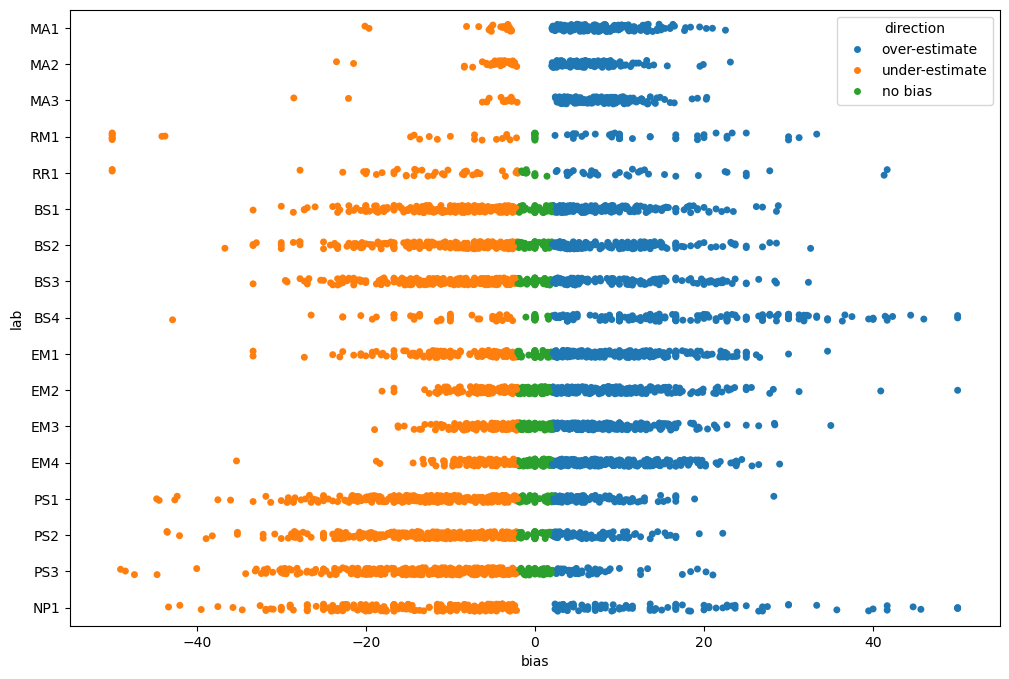

In [18]:
fig = plt.figure(figsize=(12, 8))
sns.stripplot(data=hf_choosed, y='lab', x='bias', hue='direction')

<Figure size 1200x1200 with 0 Axes>

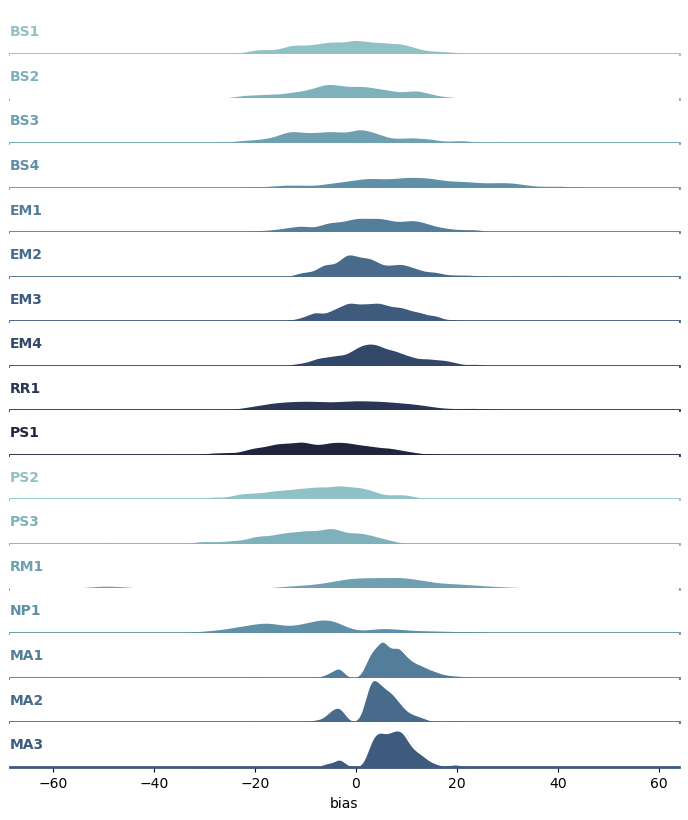

In [19]:
fig = plt.figure(figsize=(12, 12))
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(pdhf, row='lab', hue='lab', aspect=15, height=.5, palette=pal)
g.map(sns.kdeplot, 'bias', clip_on=False, fill=True, alpha=1, bw_adjust=.5, linewidth=1.5)
g.map(sns.kdeplot, 'bias', clip_on=False, color="w", lw=2, bw_adjust=.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .5, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, 'bias')

g.figure.subplots_adjust(hspace=-.002)

g.set_titles("")
g.set(yticks=[], ylabel="")
# g.set(xticks=[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50], xlabel="bias")
g.despine(bottom=True, left=True)